### Joshua Koonce
# Plant Seedling Image Classification

# Convolutional Neural Networks Project

The objective of this project is to create a Convolutional Neural Network that can accurately identify seedlings presented to it in the form of image files.

The project will use a dataset from Kaggle that has been condensed down to a reasonable size for class purposes by the academic staff.

Since the data will be image data, there is no data dictionary for this project. The images and truth labels will be imported and processed.

Import the necessary libraries:

In [1]:
import numpy as np # arrays
import pandas as pd # dataframes for displaying results tables
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # fancy styling
import cv2 # image manipulation
import tensorflow as tf # neural nets
import os # operating system functions
import gc
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

sns.set()
sns.set_style('whitegrid')

# Set the random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

Check GPU compute is enabled. Tensorflow can see the GPU and use it.

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load Data and Summary

Load the images from the provided files. For this project it's more practical to keep the data in numpy arrays instead of pandas dataframes as the data is not tabular in nature.

In [3]:
images = np.load('images.npy')
classes = np.loadtxt('labels.csv', dtype=str, delimiter=',', skiprows=1)

text_classes = classes

print('images shape: ' + str(images.shape))
print('classes shape: ' + str(classes.shape))

images shape: (4750, 128, 128, 3)
classes shape: (4750,)


We have 4750 color images with a resolution of 128x128.

Store the unique labels in the dataset.

In [4]:
unique_classes = np.unique(classes)
print(unique_classes)

['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']


Store the starting and ending index of the first image in each class for evaluation later.

In [5]:
class_indices = []

for cl in unique_classes:
    first = np.where(classes == cl)[0][0]
    last = np.where(classes == cl)[0][-1]
    class_indices.append((first, last))

In [6]:
class_indices

[(3833, 4095),
 (2034, 2423),
 (2424, 2710),
 (1423, 2033),
 (1202, 1422),
 (496, 970),
 (4096, 4749),
 (3612, 3832),
 (2711, 3226),
 (971, 1201),
 (0, 495),
 (3227, 3611)]

# Exploratory Data Analysis

Class balance assessment:

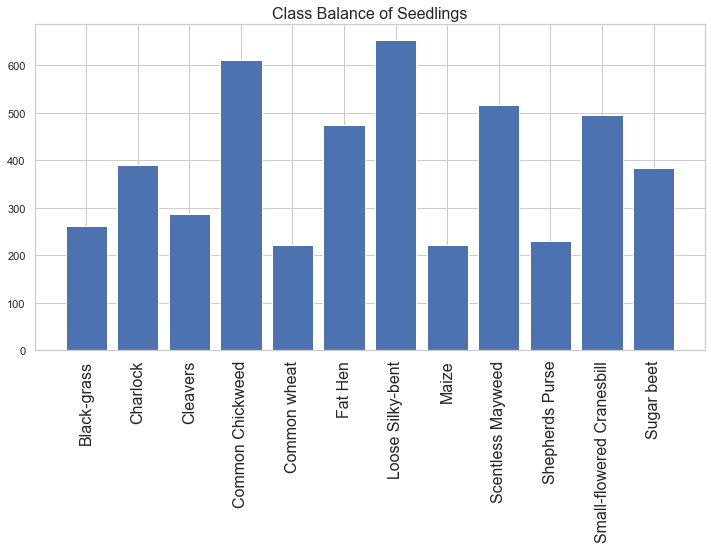

In [7]:
plt.figure(figsize=(12,6))
plt.title("Class Balance of Seedlings", fontsize=16)
plt.bar(np.unique(classes, return_counts=True)[0], np.unique(classes, return_counts=True)[1])
plt.xticks(rotation=90, fontsize=16)
plt.show()

The classes are certainly imbalanced but there are a decent amount of samples from each class. I will try to build a model without oversampling, and if that doesn't go well, try to oversample.

Create a function to print the first image from each class so that we can evaluate image processing as it proceeds.

In [8]:
def print_firsts(image_array, class_array):
    
    plt.figure(figsize=(20,15))    
    
    for i, n in enumerate(class_indices):
        plt.subplot(3, 4, i + 1)

        ax = plt.gca()
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        plt.grid(b=None)

        plt.imshow(image_array[n[0]])
        plt.xlabel(class_array[n[0]], fontsize=16)

    plt.show()

Print an image frome each label prior to processing, to make sure the data appears loaded correctly.

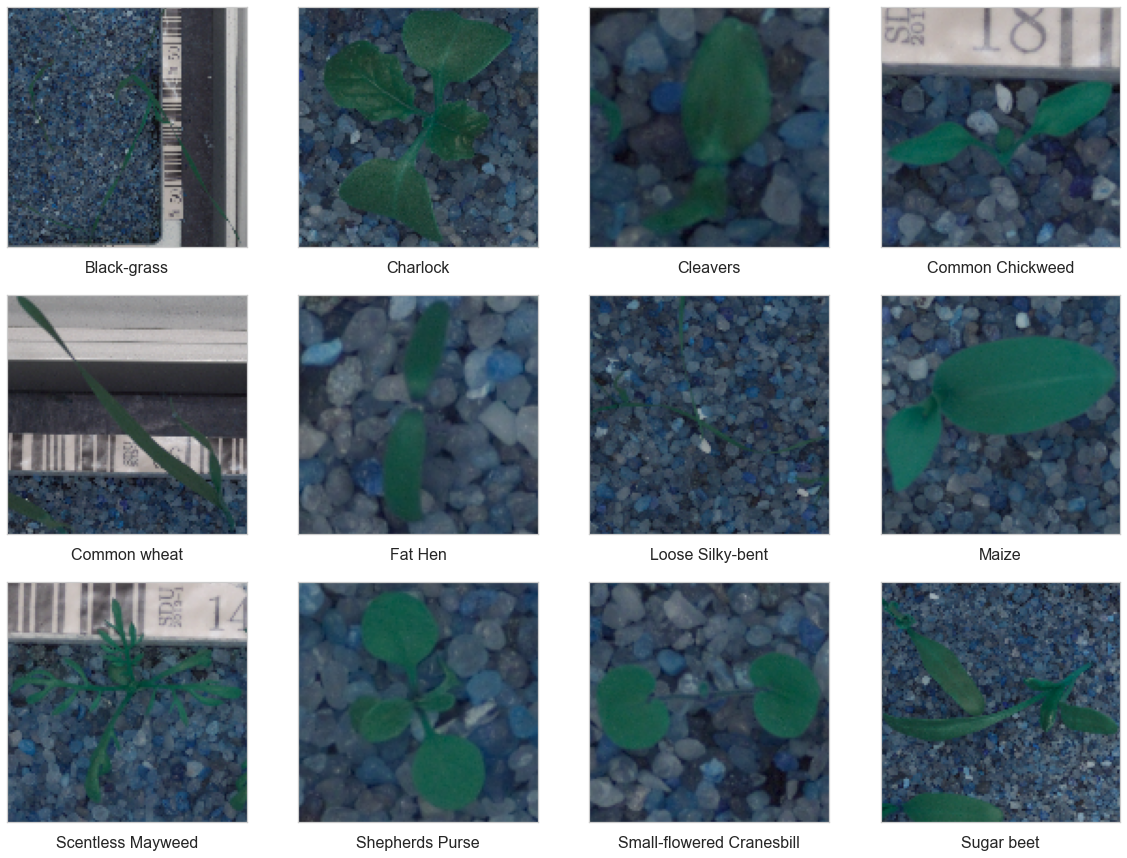

In [9]:
print_firsts(images, text_classes)

## Average Images per Class

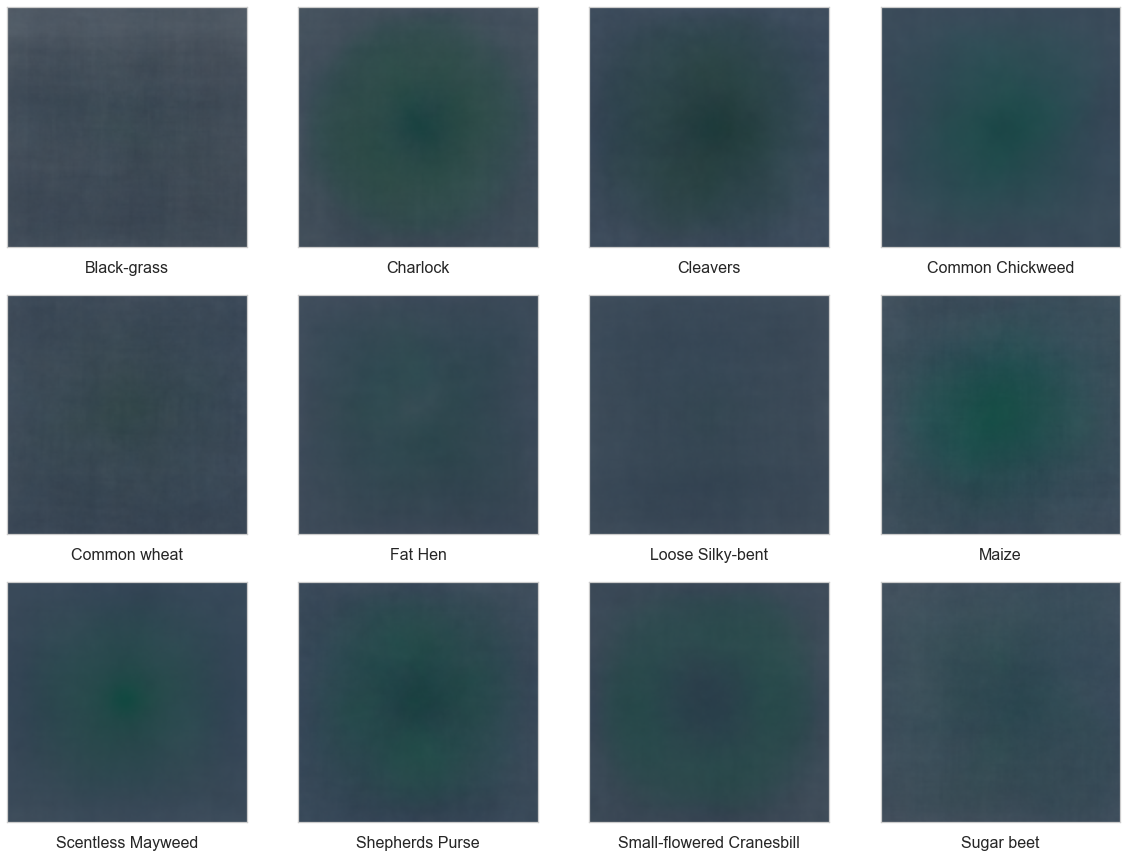

In [10]:
mean_images = []

plt.figure(figsize=(20,15))

for i, block in enumerate(class_indices):
    mean_image = np.mean(images[block[0]:block[1]] / 255, axis=0)
    mean_images.append(mean_image)
    
    plt.subplot(3, 4, i + 1)

    ax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.grid(b=None)

    plt.imshow(mean_images[i])
    plt.xlabel(unique_classes[i], fontsize=16)

plt.show()

The average image doesn't have a whole lot of insights, although some are donut shaped (opposing leaves) and others are solid center green, whereas others you can barely see any green at all (grasses)

# EDA Insights

- The images and labels appear to have a logical relationship. Similar seedlings have similar labels, so I'm confident the data has been put together properly.

- There is a class imbalance, but no class looks to have so few samples that it can't be worked around. Resampling may become useful as well.

- Since all the seedlings we're after are green, there are some opportunities to use image masking to help the models out.

# Establish a Metrics Function

This function can be called on any model I create to display it's accuracy and loss per epoch, along with a confusion matrix and the typical classification metrics.

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix 

def show_metrics(model, x_train, x_test, y_train, y_test, history):
    
    # Make predictions with the model
    y_hat_train = model.predict(x_train).argmax(axis=1)
    y_hat = model.predict(x_test).argmax(axis=1)
    
    # Convert the Test data to the same format as the predictions
    y_train = y_train.argmax(axis=1)
    y_test = y_test.argmax(axis=1)
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    ### Number of epochs run helps draw the charts
    epochs = range(1, len(acc) + 1)

    ### Plot Accuracy

    plt.figure()

    plt.plot(epochs, acc, 'b', label="Training Accuracy")
    plt.plot(epochs, val_acc, 'r', label="Validation Accuracy")
    plt.title("Training/Validation Accuracy")
    plt.legend(loc='lower right')
    plt.xlabel("epochs")
    plt.ylim(0, 1)

    plt.figure()

    ### Plot Loss
    plt.plot(epochs, loss, 'b', label="Training Loss")
    plt.plot(epochs, val_loss, 'r', label="Validation Loss")
    plt.title("Training/Validation Loss")
    plt.legend(loc='upper right')
    plt.xlabel("epochs")
    plt.ylim(min(min(loss), min(val_loss), max(max(loss), max(val_loss))))
    # Record classification results for Training Data
    train_acc = round(accuracy_score(y_train, y_hat_train), ndigits=2)
    train_rec = round(recall_score(y_train, y_hat_train, average='macro'), ndigits=2)
    train_f1 = round(f1_score(y_train, y_hat_train, average='macro'), ndigits=2)

    print("\n\nTraining Set Metrics: ")
    print('Accuracy: ', train_acc)
    print('Recall: ', train_rec)
    print('F1: ', train_f1)
    
    # Record classification results for Test Data
    test_acc = round(accuracy_score(y_test, y_hat), ndigits=2)
    test_rec = round(recall_score(y_test, y_hat, average='macro'), ndigits=2)
    test_f1 = round(f1_score(y_test, y_hat, average='macro'), ndigits=2)

    print("\nTest Set Metrics: ")
    print('Accuracy: ', test_acc)
    print('Recall: ', test_rec)
    print('F1: ', test_f1)
    print('\n')

    # create the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_hat)

    plt.figure()

    # create the heatmap display
    heatmap = sns.heatmap(conf_matrix, cmap='magma', annot=True, fmt='d');
    heatmap.set_ylabel('actual')
    heatmap.set_xlabel('prediction')
    heatmap.plot()

    ### Clean up memory
    gc.collect()

# Baseline Model

First I'm going to run a **simple baseline model** on the unprocessed images with no class balancing, then run the same model on the processed images to see if it's making a difference in learning. I'll then attempt an oversample of minority classes if it's not getting the results I want. **THEN** I'll see if I can improve the performance with more complexity.

To do that I'm going to have to binarize the labels here and then do a test/train split.

In [12]:
from sklearn.preprocessing import LabelBinarizer

binarizer = LabelBinarizer()
classes = binarizer.fit_transform(classes)

Import necessary Keras functionality, set options for the models.

Options I'm keeping consistent throughout modeling:
- Validation split of 30%
- Epochs at 400 max
- Categorical Crossentropy loss function
- Optimizer: Adam with a starting learning rate of .001
- Callbacks: Automated reduction of learning rate and early stopping based on validation loss progress

In [13]:
from keras import layers # provides access to the various layer types available
from keras import models
from keras import optimizers
from keras.callbacks import EarlyStopping # allows us to stop in the middle of learning if a pre-determined performance level is achieved
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

Create a function to run any passed model, re-create the train/test split with the same seed, fit the model, and provide metrics and results:

### Establish Macro-Level Hyperparameters

In [14]:
batch_size=64
validation_split=.3
epochs=1000

# loss is Categorical Crossentropy for multi-class classification
loss = tf.keras.losses.CategoricalCrossentropy()

# Using the Adamax optimizer with a coarse initial learning rate that will be automatically adjusted 
optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

# Implementing auto-learning-rate-reduction and early stopping callbacks that use the best weights achieved
lr = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.9, min_lr=0.00001)

# Early Stopping: restore_best_weights means the model will use the best results instead of the last epoch
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Best weights: saving them to disk. (Not needed for this project due to best results saved above in EarlyStopping)
bw = ModelCheckpoint('best_weights.h5', monitor='val_acc', verbose=False, save_best_only=True, mode='max')

callbacks = [lr, es, bw]

## Function to Run Models

In [15]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

def Run_Model(model, x, y):

    # Create a holdout dataset to split into train/test, set 30% aside for final test
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=.3, random_state=seed)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=validation_split, random_state=seed)
    
    generator = ImageDataGenerator() # note I didn't use augmentation because it made the results WORSE
    
    train_generator = generator.flow(x_train, y_train, batch_size=batch_size)
    val_generator = generator.flow(x_val, y_val, batch_size=batch_size)

    # compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])
    
    # summarize the model
    model.summary()
    
    history = model.fit(train_generator, 
                     steps_per_epoch=len(x_train) // batch_size,
                     epochs=epochs, 
                     validation_data=val_generator, 
                     validation_steps=len(x_val) // batch_size,
                     callbacks=callbacks)
    
    show_metrics(model, x_train, x_test, y_train, y_test, history)
    
    return history

## Define the Baseline Model
Build the baseline model, creating a function to return it so that it can be easily re-used without all the retyping of layers. This will just be used to test performance before and after data processing to see if it's benefiting the model.

In [16]:
def baseline_model():
    
    model = models.Sequential()

    model.add(layers.Conv2D(32, kernel_size=3, activation='relu', padding = 'same', input_shape=(128, 128, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(32, kernel_size=3, activation='relu', padding = 'same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(32, kernel_size=3, activation='relu', padding = 'same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Dropout(.25))
    model.add(layers.Flatten()) # drops the inputs into a single dimension

    model.add(layers.Dense(256, activation='relu'))
    
    model.add(layers.Dropout(.5))
    
    # output layer
    model.add(layers.Dense(12, activation='softmax'))

    
    return model

### Running the Baseline Model on Completely Unprocessed Images

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0

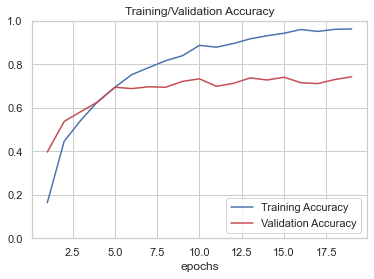

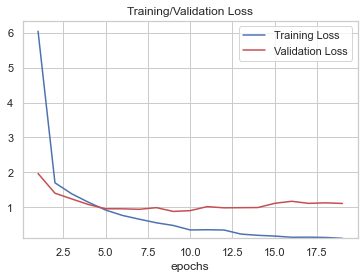

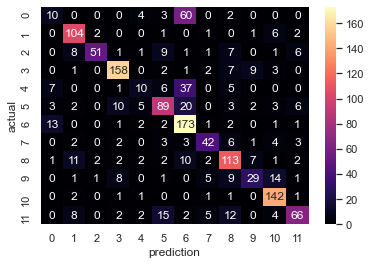

In [17]:
%%time
history_original_images = Run_Model(baseline_model(), images, classes)

So the model is overfitting as can be seen by its accuracy that isn't translating as well to the validation and test sets, but it's performing decently considering the images are completely unprocessed and the model is not complex. Many classes are being misclassified at this stage.

I'll now do some pre-processing on the images and see how it impacts the model. I'll use the same model for an apples to apples comparison.

# Image Pre-Processing and Improving the Model

### Denoising Images (Gaussian Filtering)

CNNs work better on slightly blurred images, usually, because noise is smoothed out.

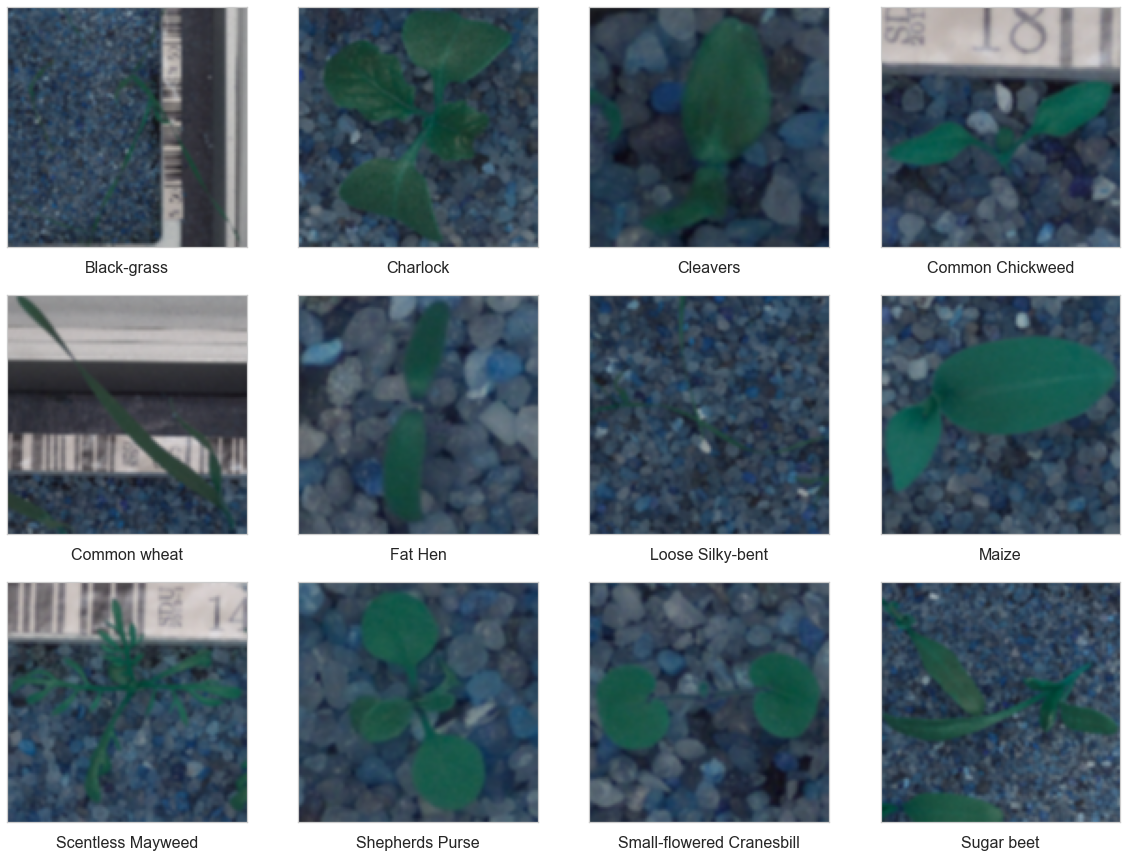

In [18]:
filtered_images = []

for image in images:
    filtered_images.append(cv2.GaussianBlur(image, (3, 3), 0))
    
filtered_images = np.array(filtered_images)
print_firsts(filtered_images, text_classes)

### RGB to HSV

This will make it easier to filter out objects and background that we don't want. It makes non-plant colors stick out.

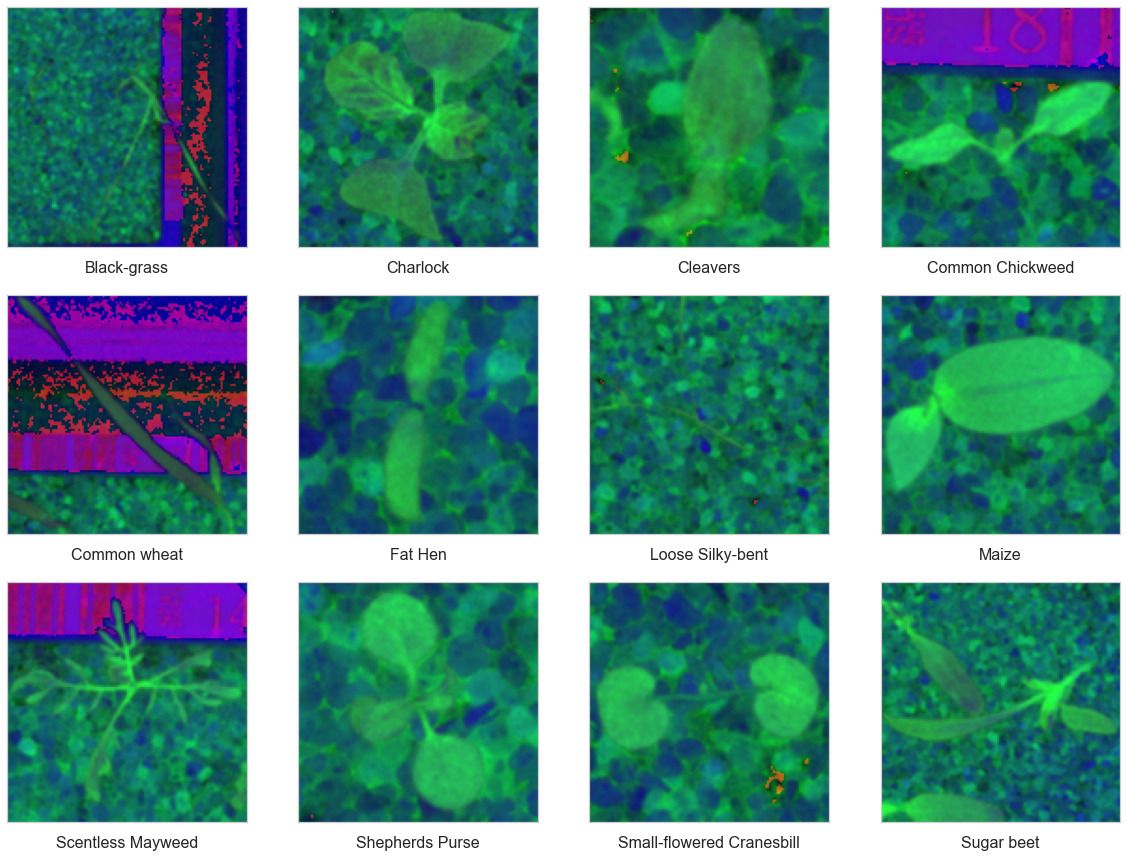

In [19]:
hsv_images = []

for image in filtered_images:
    hsv_images.append(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))

hsv_images = np.array(hsv_images)
print_firsts(hsv_images, text_classes)

### Average Images in HSV
To bring out a little more detail in the average images.

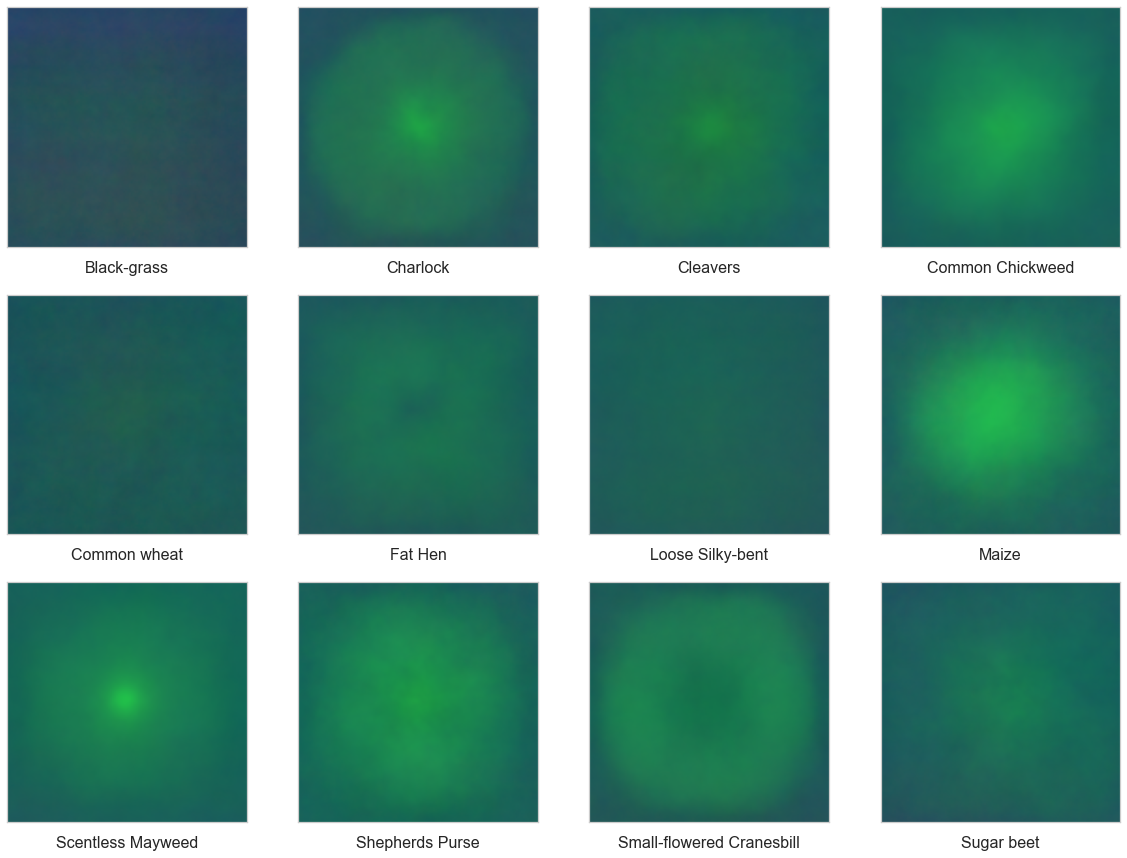

In [20]:
mean_images = []

plt.figure(figsize=(20,15))

for i, block in enumerate(class_indices):
    mean_image = np.mean(hsv_images[block[0]:block[1]] / 255, axis=0)
    mean_images.append(mean_image)
    
    plt.subplot(3, 4, i + 1)

    ax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.grid(b=None)

    plt.imshow(mean_images[i])
    plt.xlabel(unique_classes[i], fontsize=16)

plt.show()

You can definitely see a little more variety and defining features of the average images when converted to the HSV color range. Seedlings have definite cirvular patterns, some solid, some hollow. Many with bright centers.

### Masking Out Backgrounds

Masking out objects in the scene that we don't need will help isolate the plant structure. I do this via the HSV colors.  Essentially i'm just filtering out everything that isn't green.

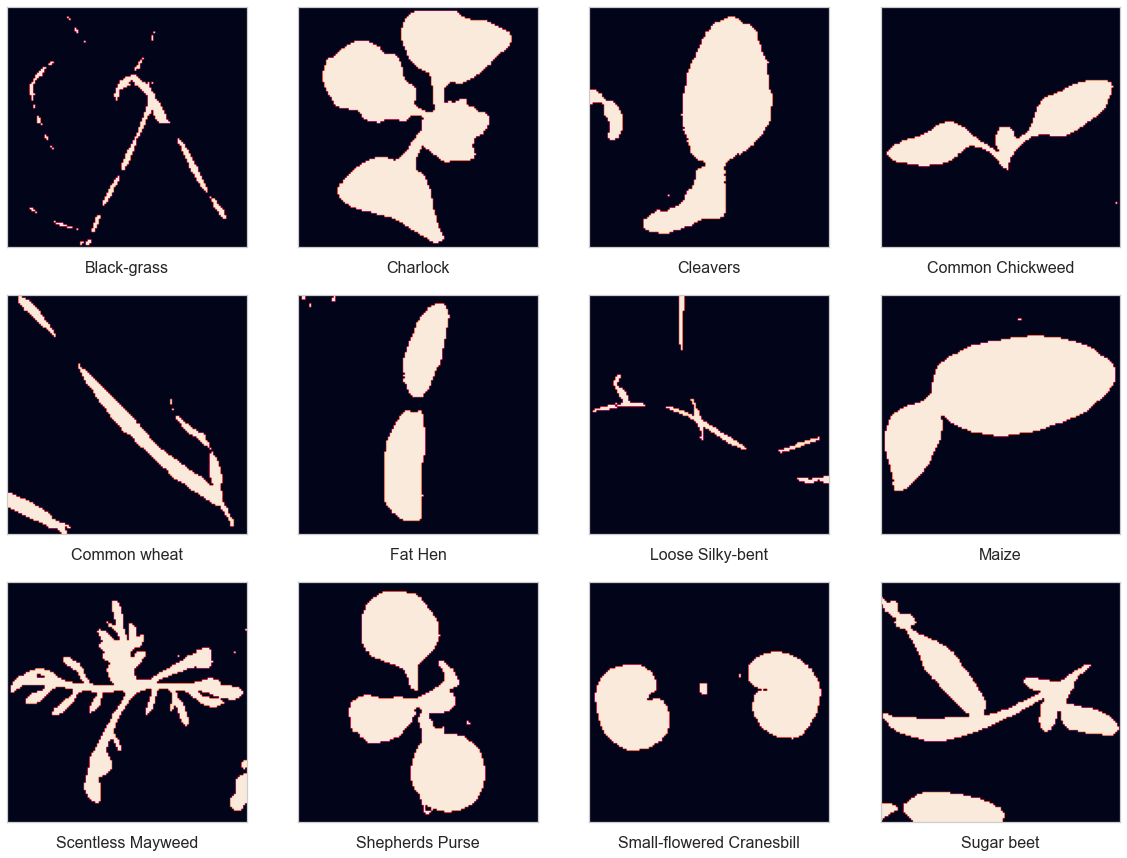

In [21]:
masks = []

low = (25, 40, 50)
high = (75, 255, 255)

for image in hsv_images:
    
    # create a mask based on RGB ranges to filter out (we can do this with all green plants)
    # creates ellipses and draws them in on the desired color spectrum
    mask = cv2.inRange(image, low, high)
    
    masks.append(mask)

masks = np.array(masks)
print_firsts(masks, text_classes)

### Applying the Masks to the Original Denoised Images

Now that I have masks created, I'm going to apply the masks to the denoised images from above to get us down to what we're interested in, the plants themselves.

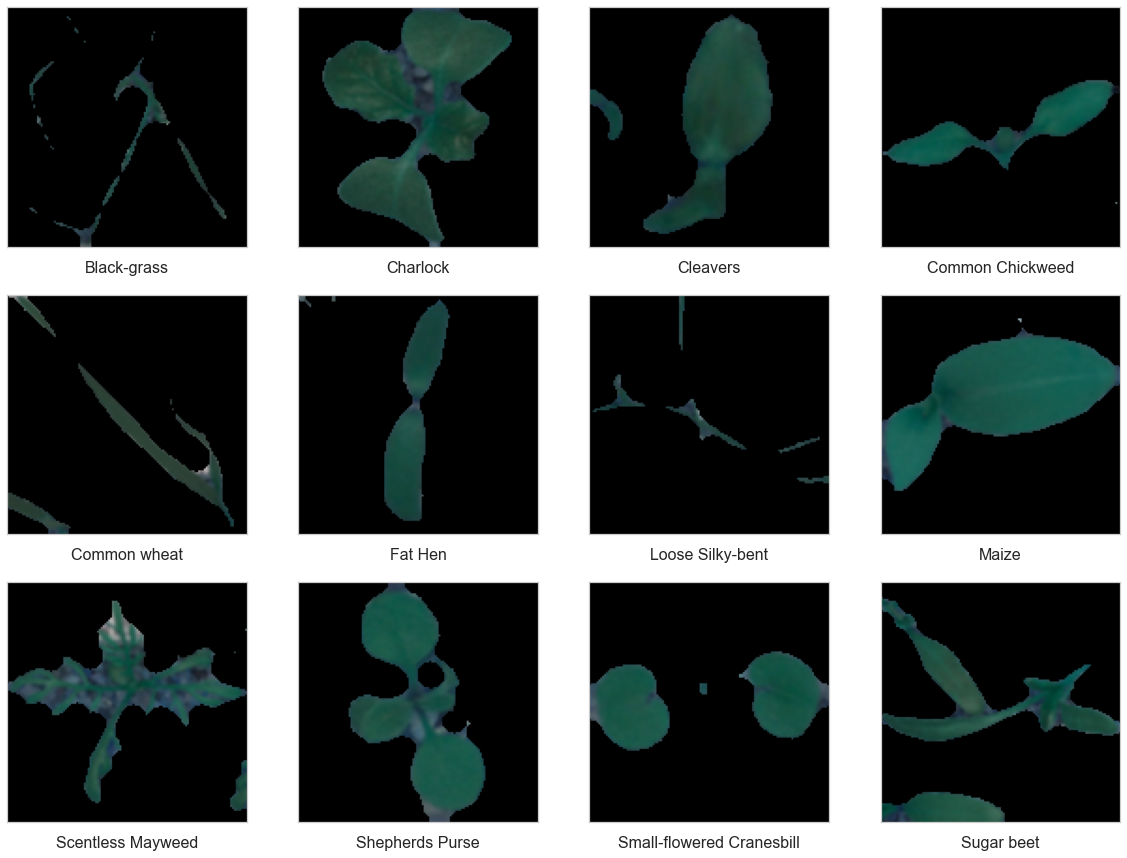

In [22]:
masked_images = []

for i, mask in enumerate(masks):
    
    # create the masks shape based off the high/low filter and apply to the denoised images
    shape = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, shape)

    # select everything that isn't black (masked out)
    boolean_mask = mask > 0

    # create the new image using the masks
    masked_image = np.zeros_like(filtered_images[i], np.uint8)
    masked_image[boolean_mask] = filtered_images[i][boolean_mask]
    
    masked_images.append(masked_image)

masked_images = np.array(masked_images)
print_firsts(masked_images, text_classes)

### Normalization

Since pixels can only have values between 0-255, dividing by the max value normalizes the data by creating a proportion that falls within 0-1. This can help the learning algorithm.

Note that rather than normalizing the images this way, you can use a Gaussian filter within the model itself. There's a Keras layer just for doing so.

In [23]:
normalized_images = np.array(masked_images) / 255

### Baseline Model on Processed Images
This will be compared to the baseline model on the unprocessed images to see how much predictive performance has improved just by processing the images into a different format.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 32)       

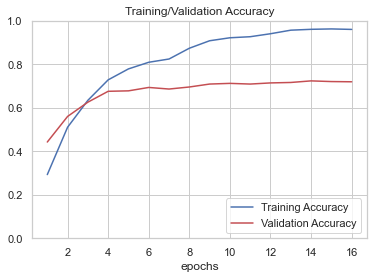

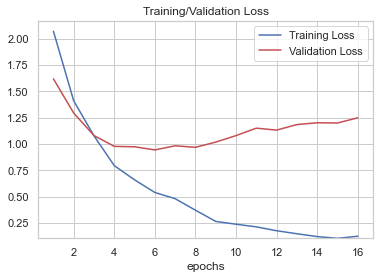

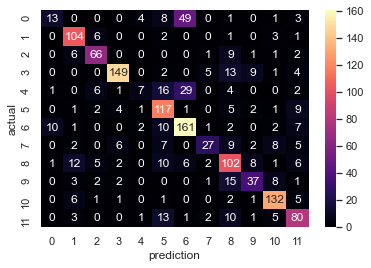

In [24]:
%%time
history_processed_images = Run_Model(baseline_model(), normalized_images, classes)

The model is still misclassifying some, but it has improved from the unprocessed images considerably. This bodes well for future steps.

### Oversampling

An imbalanced class situation can make it difficult for the algorithms to differentiate between classes, so I'm going to oversample the dataset.

I didn't get good results with SMOTE on images, so instead I'm using a basic Random Oversampler to resample with replacement and get all the classes balanced.

In [25]:
from imblearn.over_sampling import RandomOverSampler

In [26]:
images_reshaped = normalized_images.reshape(4750, 128 * 128 * 3)
images_reshaped.shape

(4750, 49152)

In [27]:
ros = RandomOverSampler(random_state=seed)
x_ros, y_ros = ros.fit_resample(images_reshaped, classes)

In [28]:
x_ros = x_ros.reshape(7848, 128, 128, 3)

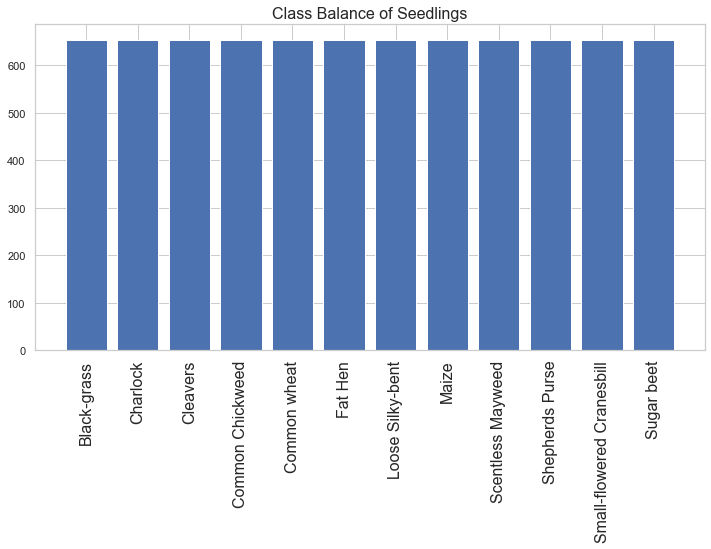

In [29]:
plt.figure(figsize=(12,6))
plt.title("Class Balance of Seedlings", fontsize=16)
plt.bar(np.unique(binarizer.inverse_transform(y_ros), return_counts=True)[0], np.unique(binarizer.inverse_transform(y_ros), return_counts=True)[1])
plt.xticks(rotation=90, fontsize=16)
plt.show()

### Baseline Model on Oversampled Images
This will allow me to see what predictivce performance improvement I've achieved simply by oversampling the imbalanced classes.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)       

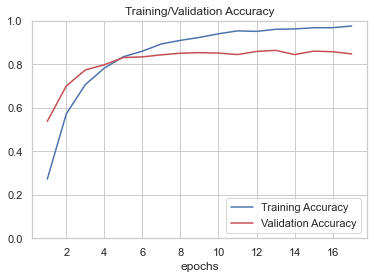

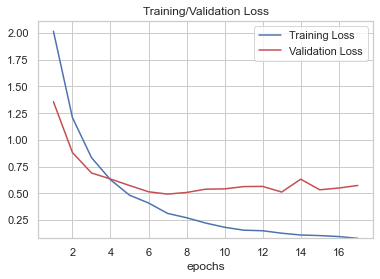

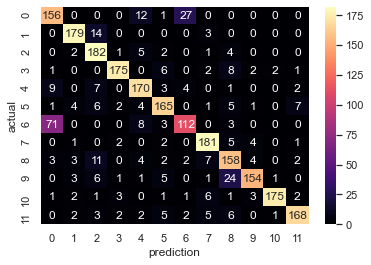

In [30]:
%%time
history_ros = Run_Model(baseline_model(), x_ros, y_ros)

The baseline model is actually performing really well on the Test set. There is some overtraining but I think this is almost as good as it's going to get with this many images in the dataset.

## Increasing the Model Complexity

Key changes to this model are a change of the kernel size to 5 on the convolution laters and more dense neurons.

In [31]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size=3, activation='relu', padding = 'same', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, kernel_size=3, activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, kernel_size=3, activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, kernel_size=3, activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Dropout(.25))
model.add(layers.Flatten()) # drops the inputs into a single dimension

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(.5))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(.5))

# output layer
model.add(layers.Dense(12, activation='softmax'))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 32)       

Epoch 58/1000
60/60 - 1s - loss: 0.2978 - acc: 0.8881 - val_loss: 0.3860 - val_acc: 0.8781

Epoch 00058: ReduceLROnPlateau reducing learning rate to 7.178980231401511e-05.
Epoch 59/1000
60/60 - 1s - loss: 0.3027 - acc: 0.8868 - val_loss: 0.3864 - val_acc: 0.8800
Epoch 60/1000
60/60 - 1s - loss: 0.2966 - acc: 0.8855 - val_loss: 0.3798 - val_acc: 0.8725

Epoch 00060: ReduceLROnPlateau reducing learning rate to 6.461082011810504e-05.
Epoch 61/1000
60/60 - 1s - loss: 0.2900 - acc: 0.8913 - val_loss: 0.3842 - val_acc: 0.8769
Epoch 62/1000
60/60 - 1s - loss: 0.2681 - acc: 0.8995 - val_loss: 0.3890 - val_acc: 0.8806

Epoch 00062: ReduceLROnPlateau reducing learning rate to 5.8149741380475466e-05.
Epoch 63/1000
60/60 - 1s - loss: 0.2806 - acc: 0.8908 - val_loss: 0.3853 - val_acc: 0.8769
Epoch 64/1000
60/60 - 1s - loss: 0.2803 - acc: 0.8939 - val_loss: 0.3761 - val_acc: 0.8775

Epoch 00064: ReduceLROnPlateau reducing learning rate to 5.233476658759173e-05.


Training Set Metrics: 
Accuracy:  0.

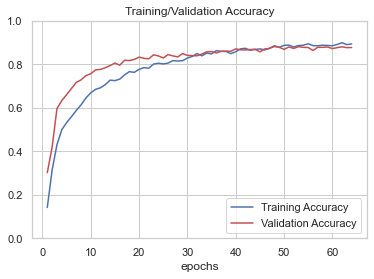

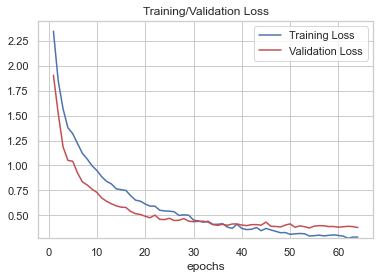

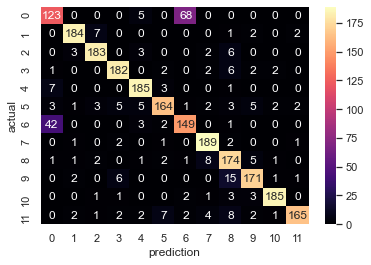

In [32]:
history_ros2 = Run_Model(model, x_ros, y_ros)

# Conclusion and Takeaways
Although the test/val performance is lagging behind the training performance a bit still, the model is decently fit now. I suspect some of the inability to get higher performance is linked to us using a pared down dataset for this project.

Overall, this model provides roughly 86% accuracy/recall in identifying a seedling correctly.

It struggles in differentiating between seedling 0 and 6 (Black Grass and Loose Silky Bent), most likely because they have very basic profiles and no extremely defining characteristics between the two. If the end goal is to identify seedlings vs. grasses then this may not be a problem.

Other things I tried that were NOT successful were using the ImageDataGenerator's options to rotate, zoom, and otherwise vary images in order to create more avenues for the algorithm to pick up on. Gaussian Blurring was also not seemingly helping the model, but I left it in due to project requirements.

I think a key takeaway here is the importance of properly preparing and processing images prior to building a model, particularly if you're getting poor results to begin with. The largest jumps in performance were definitely image preparation and oversampling.